<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Multi-Factor Scores


Often it is desirable to incorporate multiple factors into portfolio allocation decisions. There are different ways to combine factors. For example, you could select the top quantile of stocks based on factor `A`, then within that quantile select the top 100 stocks ranked by factor `B`. Another way, which we will look at in this notebook, is to combine multiple factors into a single score. The Altman Z-Score is an example of a multi-factor score. It assigns different weights to various fundamental ratios and sums the weighted ratios into a score. 

Another well-known multi-factor score is the Piotroski F-Score, which measures firm quality. Unlike the Altman Z-Score which sums weighted ratios, the Piotroski F-Score assigns companies 1 point for each of 9 true or false conditions, such as whether this year's return on assets is higher than last year's, resulting in a possible score of 0-9.  

In this notebook, we'll explore a simpler version of this type of boolean-based score. We will assign companies 1 point if they are "zombies" having interest coverage ratios  below 1, and 1 point if their Altman Z-Score is in the distress zone. This will result in a possible score of 0 (if neither condition is met), 1, or 2 (if both conditions are met).

To accomplish this in Pipeline, we create our True/False conditions, then convert them to 1s and 0s using the `as_factor()` method, then add the 1s and 0s to create the score:



In [1]:
from zipline.pipeline import sharadar
from codeload.fundamental_factors.universe import BaseUniverse

universe = BaseUniverse()

icr = sharadar.InterestCoverageRatio('ART', mask=universe)
altman = sharadar.AltmanZScore('ART', mask=universe)

distress_score = (icr < 1).as_factor() + (altman < 0).as_factor()

Let's create a Pipeline with our distress score, which will analyze with Alphalens:

In [ ]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AnnualizedVolatility

fundamentals = sharadar.Fundamentals.slice("ART")
marketcap = fundamentals.MARKETCAP.latest

pipeline = Pipeline(
    columns={
        'distress_score': distress_score,
        'size': marketcap.quantiles(5, mask=universe),
        'volatility': AnnualizedVolatility(mask=universe).quantiles(5)
    },
    screen=universe
)

As in the previous notebook, we need to use the `bins` argument to define bin edges for Alphalens that correspond to our 3 possible scores. Since the possible scores are 0, 1, and 2, we can define the bin edges as `[-1, 0, 1, 2]`:

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1,0.000,0.000,0.000,0.000,"19,832,056",3590.8,89.2%
2,1.000,1.000,1.000,0.000,"2,338,093",423.3,10.5%
3,2.000,2.000,2.000,0.000,"52,351",9.5,0.2%


,1D,21D,5D
Ann. alpha,-0.037,-0.038,-0.038
beta,0.048,0.197,0.120
Mean Relative Return Top Quantile (bps),-0.690,-0.152,0.217
Mean Relative Return Bottom Quantile (bps),0.235,0.114,0.178
Mean Spread (bps),-0.924,-2.211,-1.831


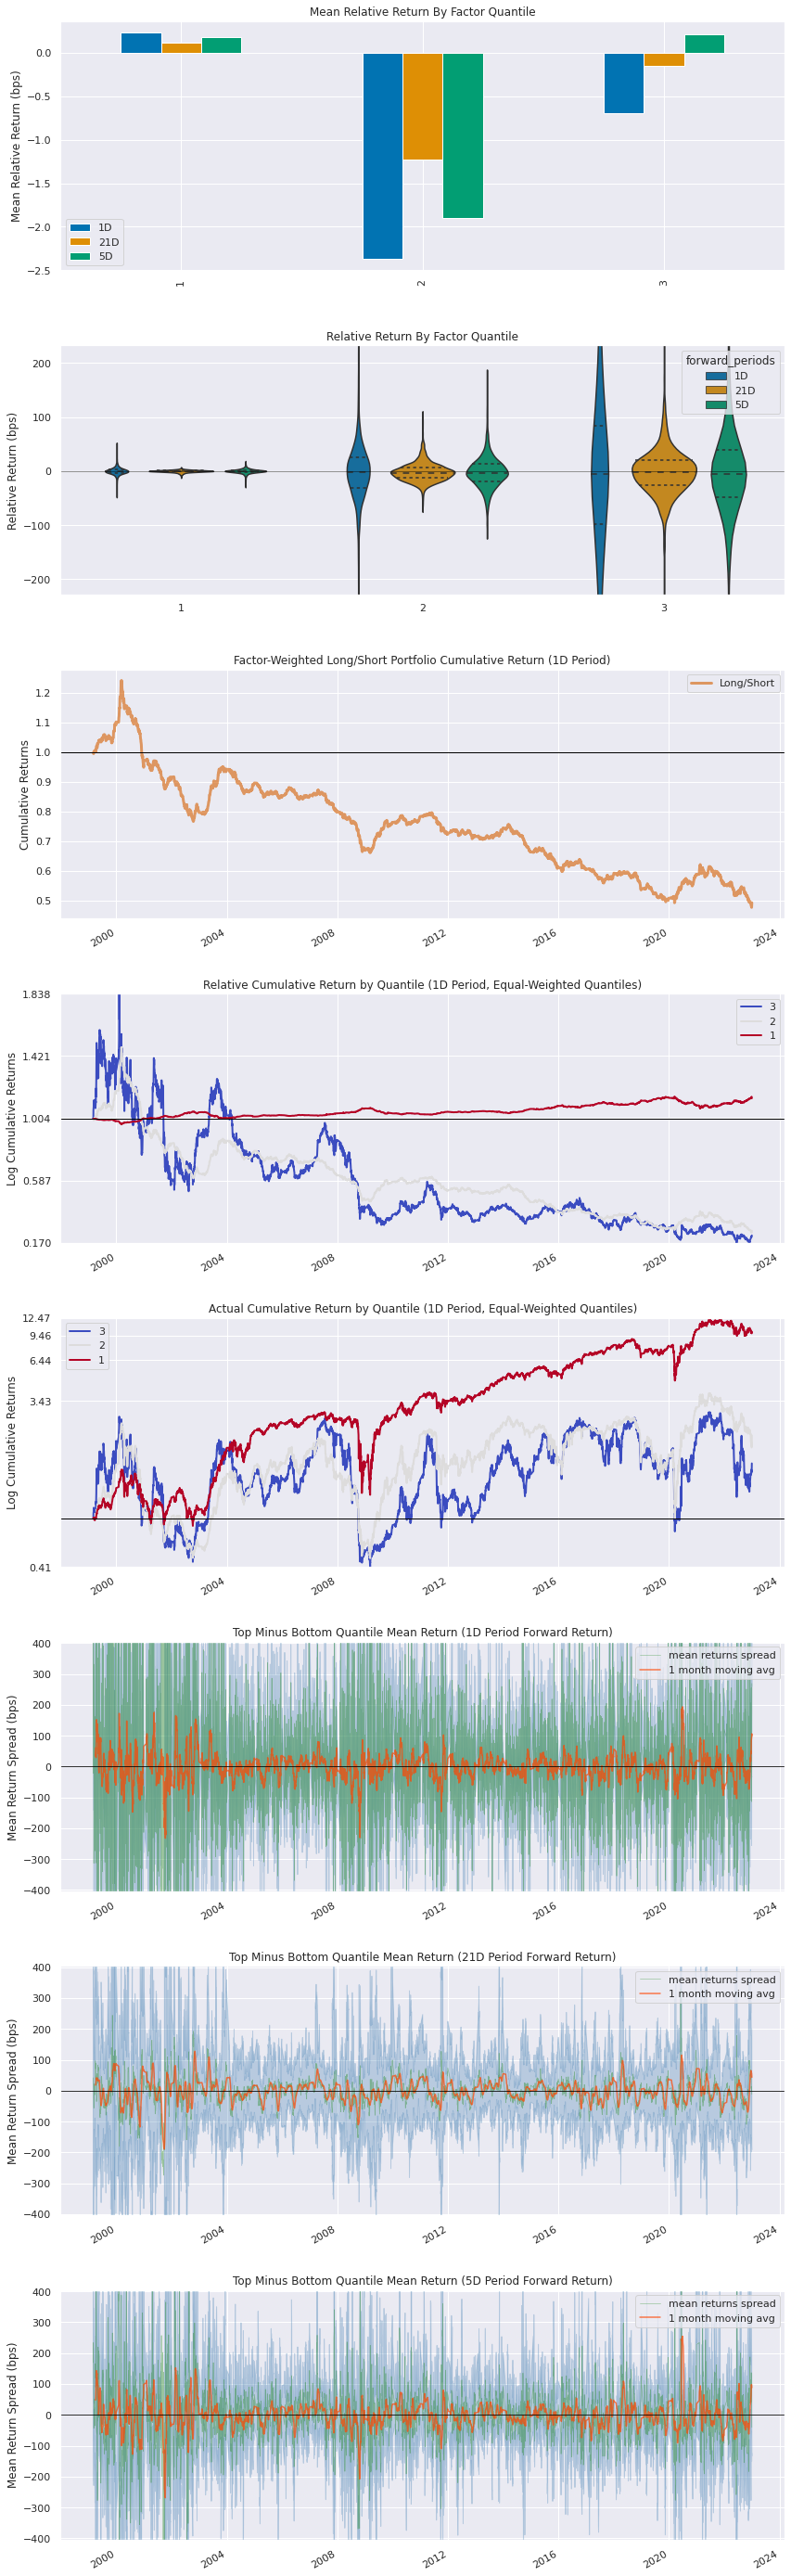

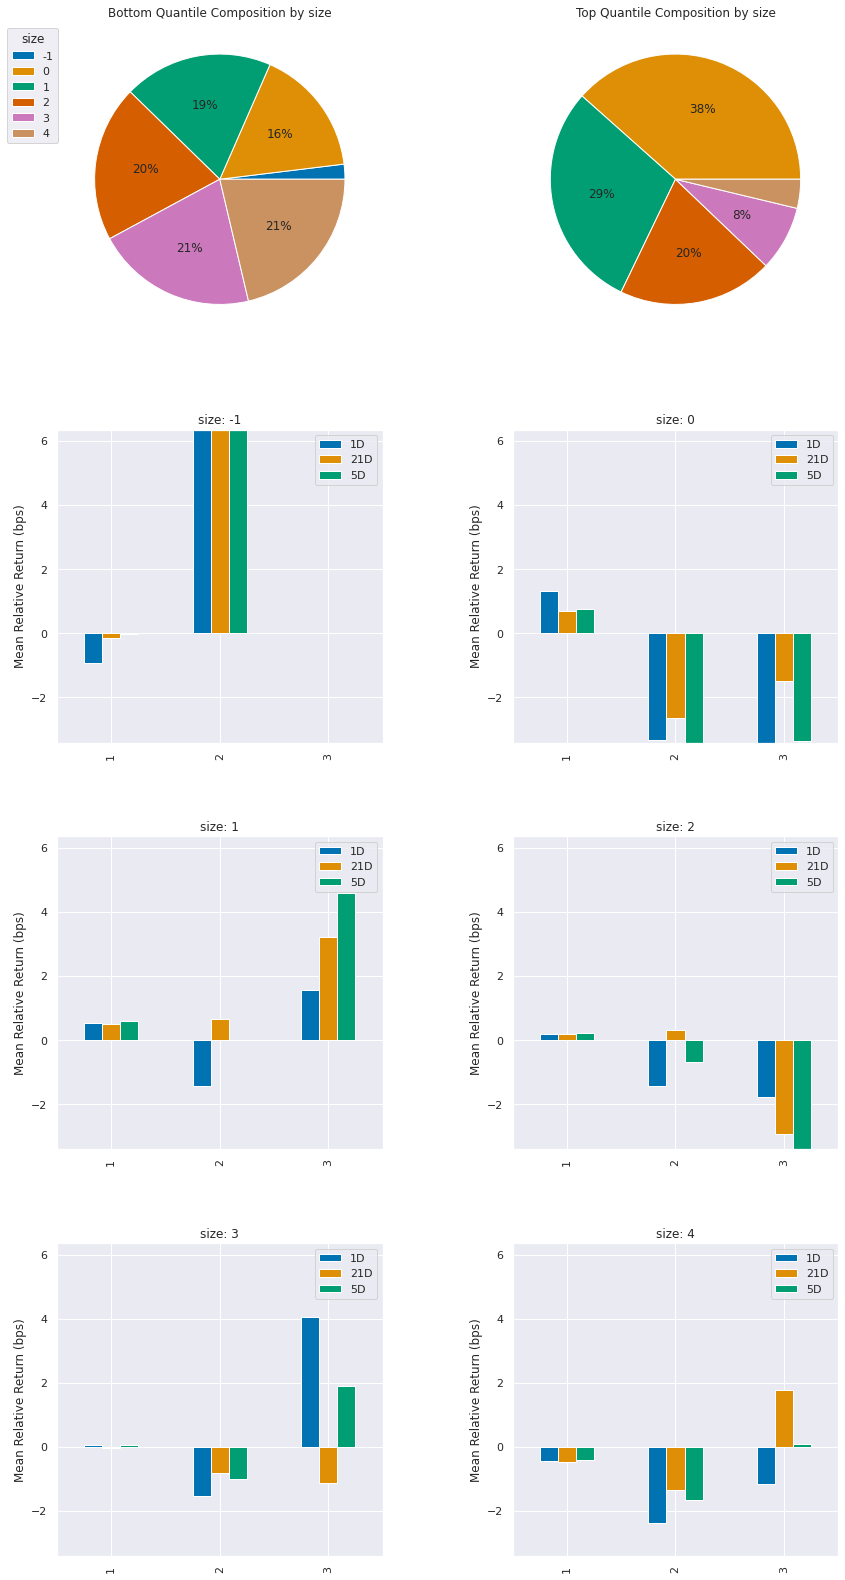

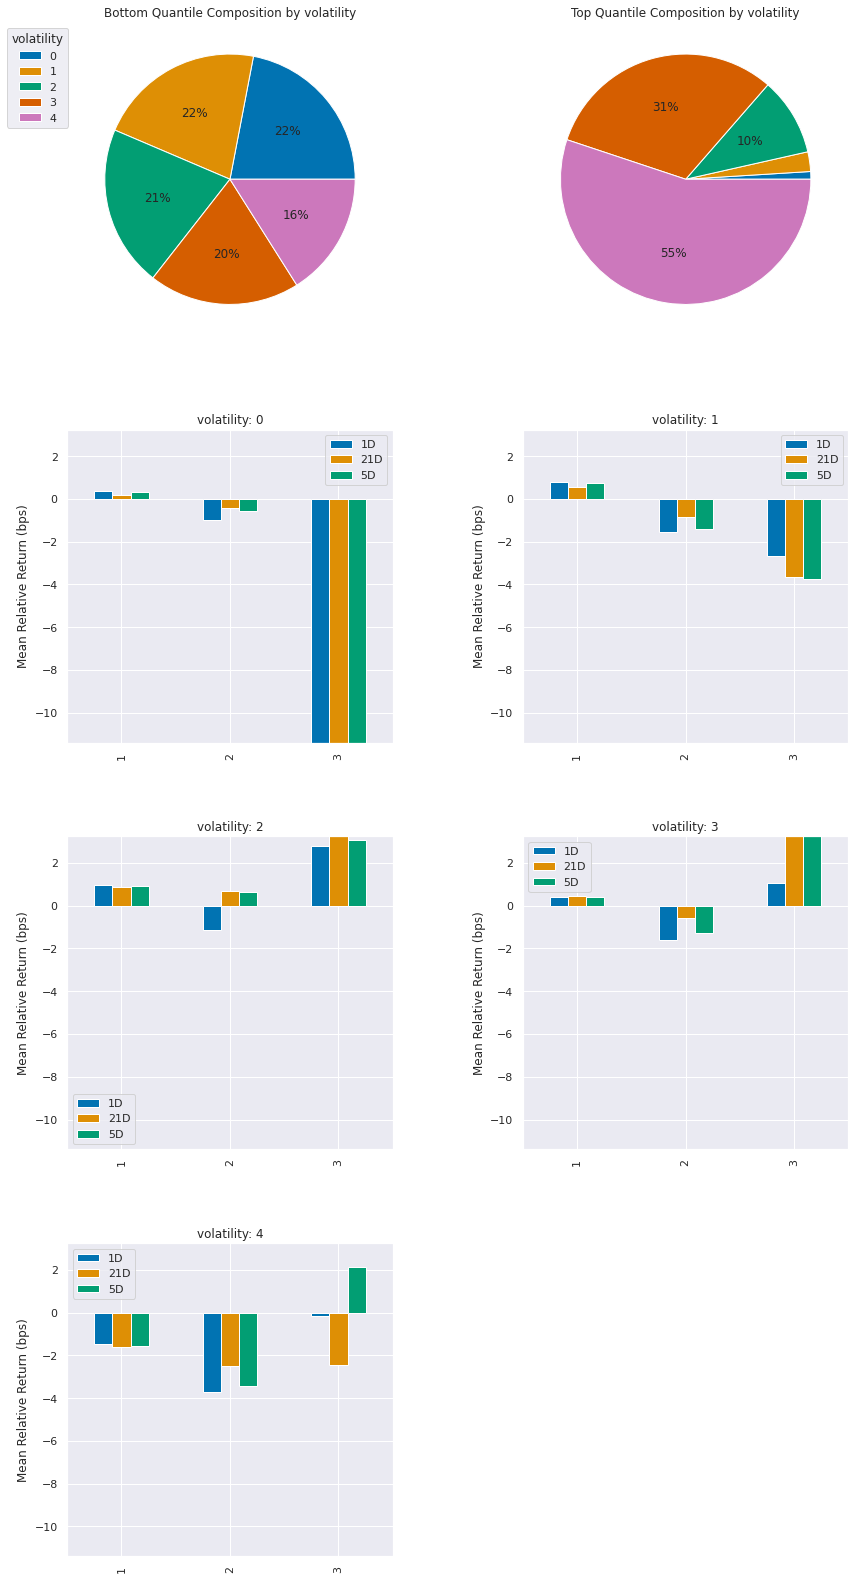

,1D,21D,5D
IC Mean,-0.017,-0.036,-0.026
IC Std.,0.048,0.067,0.057
Risk-Adjusted IC,-0.367,-0.535,-0.451
t-stat(IC),-27.240,-39.727,-33.532
p-value(IC),0.000,0.000,0.000
IC Skew,-0.157,0.287,0.017
IC Kurtosis,1.229,0.359,1.033


/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


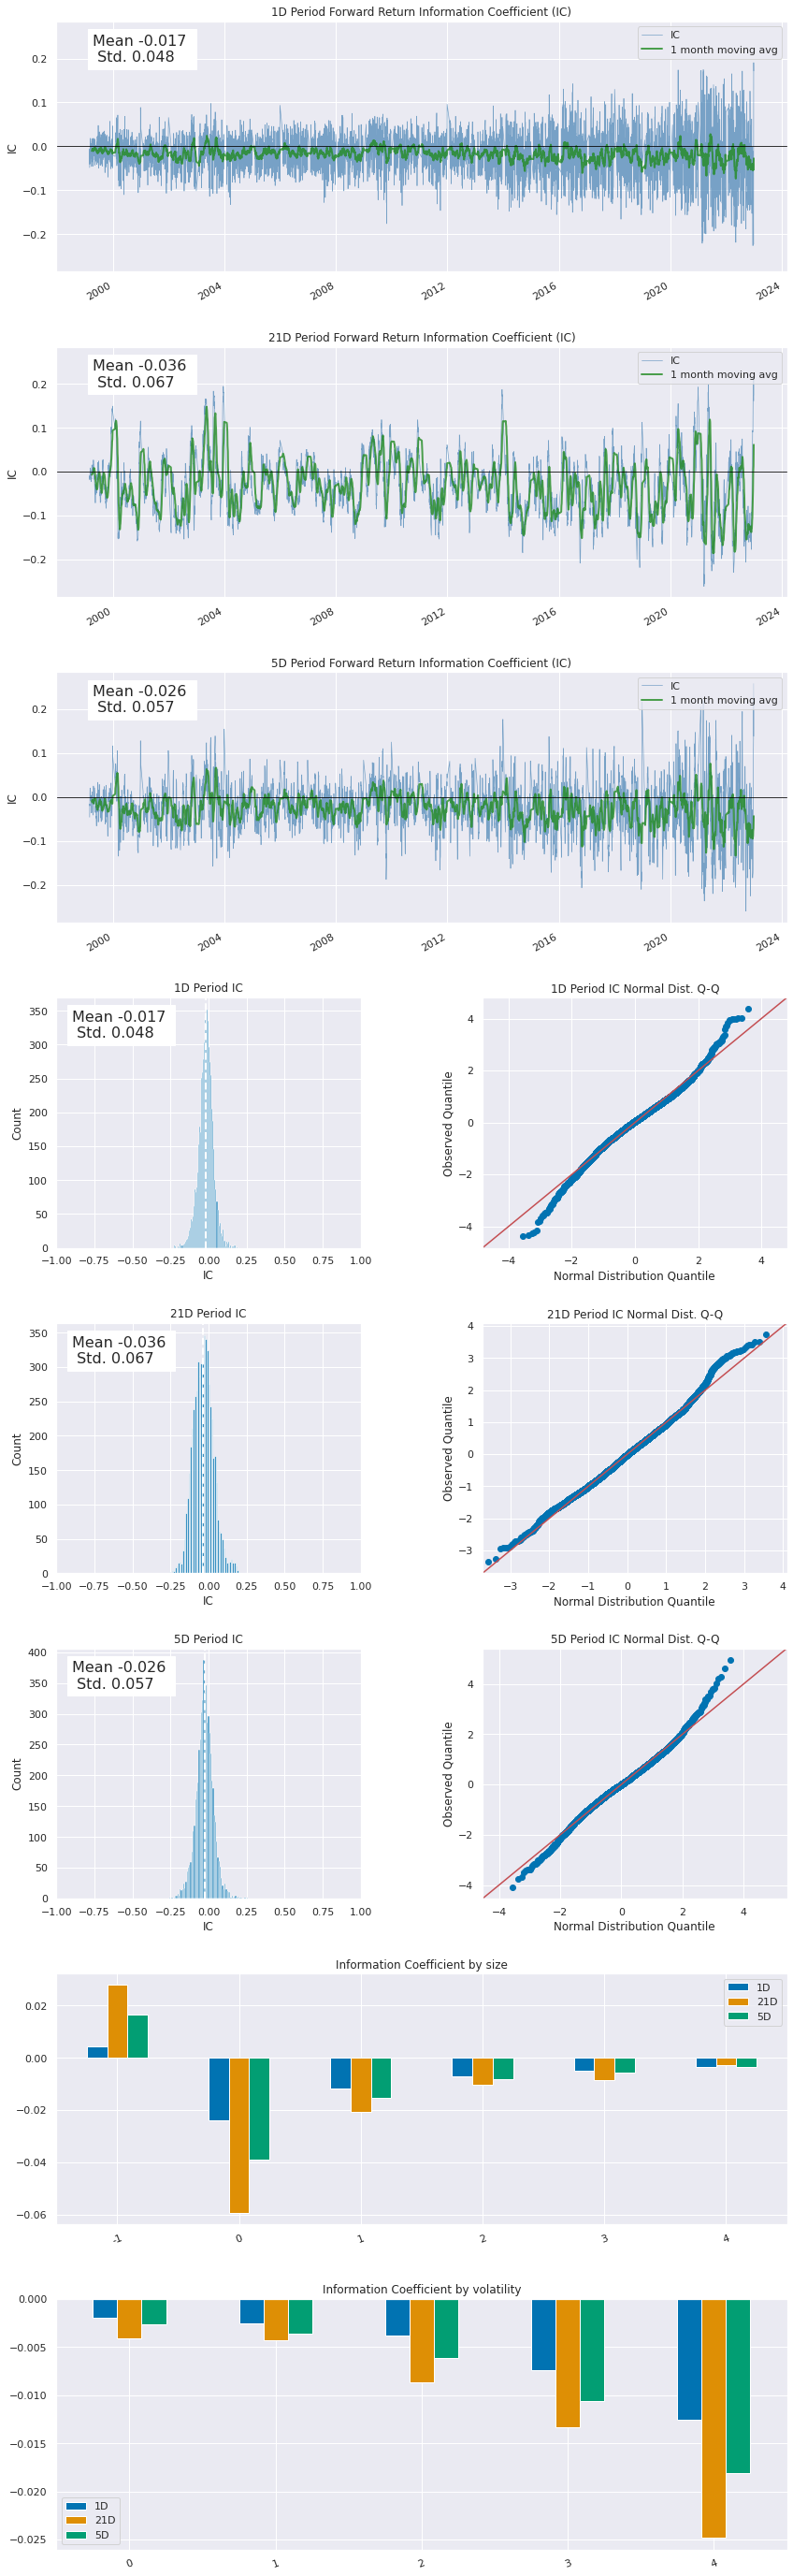

,1D,5D,21D
Quantile 1 Mean Turnover,0.003,0.012,0.041
Quantile 2 Mean Turnover,0.009,0.041,0.154
Quantile 3 Mean Turnover,0.012,0.060,0.222


,1D,21D,5D
Mean Factor Rank Autocorrelation,0.995,0.9,0.976


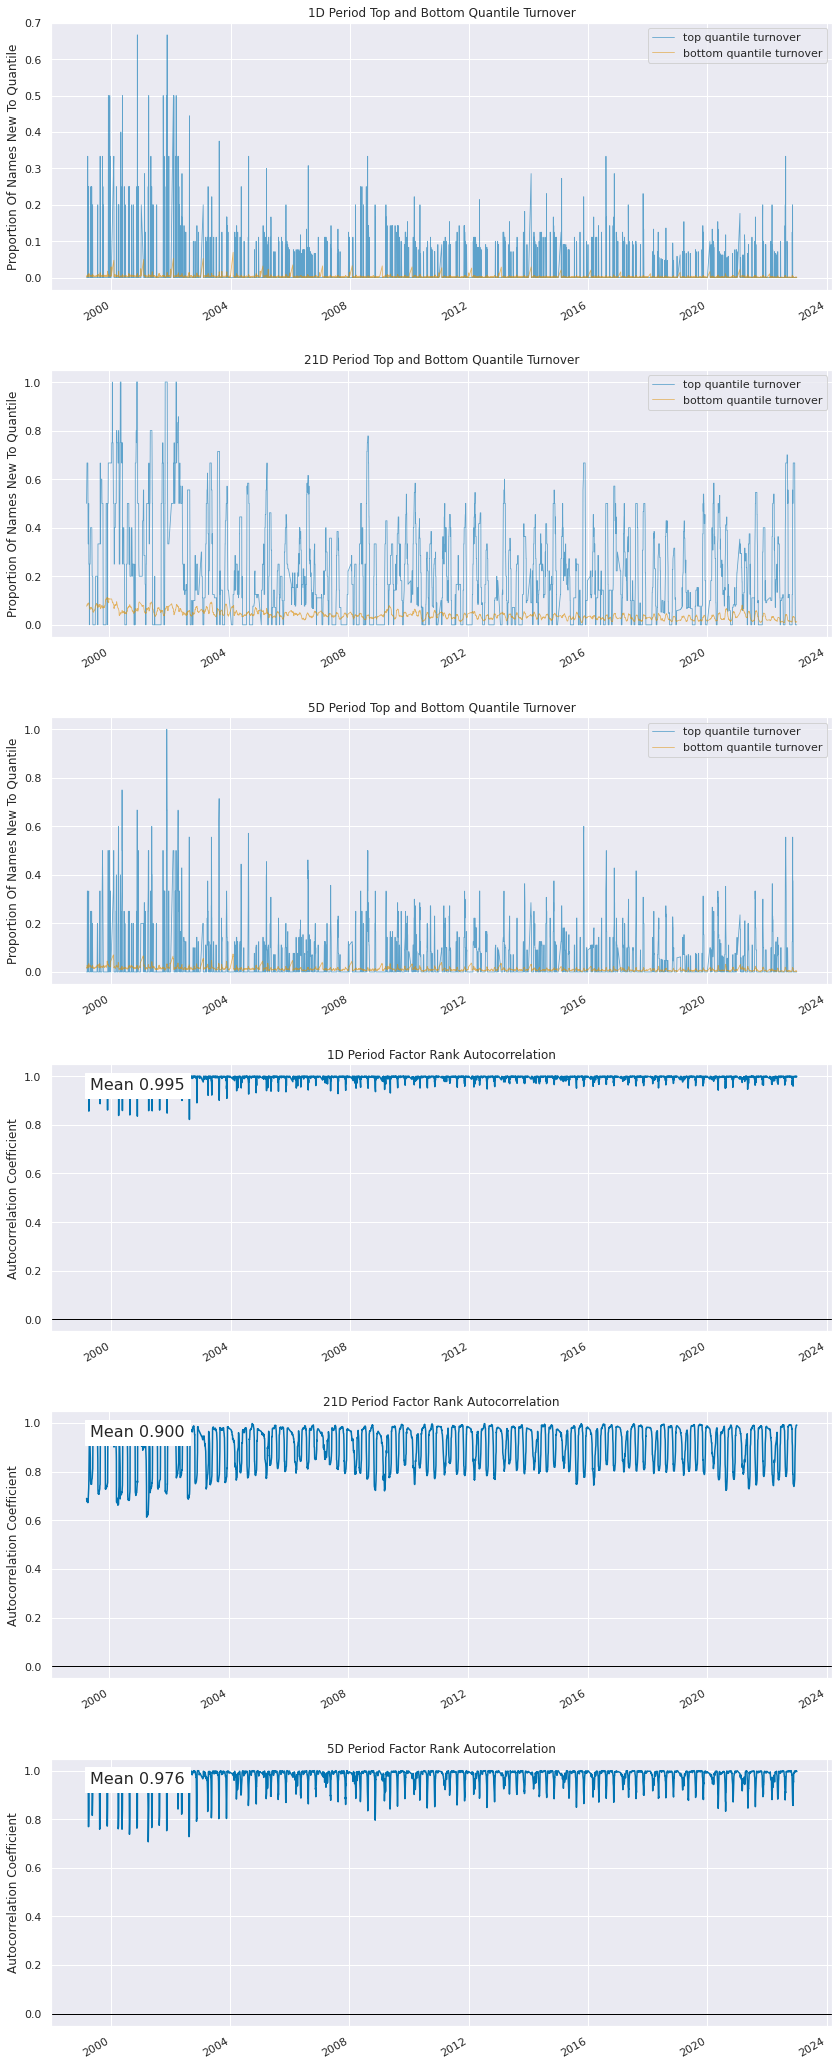

In [2]:
import alphalens as al

al.from_pipeline(
    pipeline,
    start_date="1999-02-01",
    end_date="2022-12-30",
    periods=[1, 5, 21],
    factor="distress_score",
    bins=[-1, 0, 1, 2],
    groupby=[
        "size", 
        "volatility"
    ],
    segment="Y"
)

## Tear sheet commentary

### Factor Distribution table

* `min`/`max`: Here, we can validate our bin edges. Factor quantile 1 contains score 0 (non-zombies, non-distressed); quantile 2 contains score 1 (zombies OR distressed); and quantile 3 contains score 2 (zombies AND distressed).
* `count %`: Only 0.2% of stocks fall into quantile 3, indicating that it is very rare for a company to be both a zombie and distressed.

### Returns Analysis

* `Relative Cumulative Return By Quantile`: companies that are zombies or in distress perform worse than other companies. Quantile 3 (zombies AND distressed) performs similarly to quantile 2 (zombies OR distressed). In other words, being both a zombie and distressed does not result in worse returns than being only one or the other. Combined with the tiny size of quantile 3, this suggests that the best way to combine the interest coverage ratio and Altman Z-Score is to OR them, not AND them.

---
[Back to Introduction](Introduction.ipynb) 